/Users/umutguler/ai_env/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(A) Pencereleme: X: (54008, 120, 14) | y: (54008, 24) | features: 14
(B) RF Seçimi (7 özellik): ['TotalLoad', 'Biomass', 'FossilGas', 'SolarPower', 'OffshoreWindPower', 'ExchangeContinent', 'ExchangeNordicCountries'] [Geçmiş TotalLoad ZORUNLU]

--- SHAP Analizi Başlıyor (RF modeli) ---

--- SHAP Global Feature Importance (14 feature) ---
                    feature  shap_importance  shap_rank  selected_by_rf
0                 TotalLoad     1.076927e-03          1            True
1                SolarPower     1.054825e-04          2            True
2         ExchangeContinent     7.113541e-07          3            True
3                 FossilGas     5.083622e-07          4            True
4   ExchangeNordicCountries     4.120843e-07          5            True
5                   Biomass     1.793236e-07          6            True
6            OtherRenewable     8.612845e-08          7           False
7                HydroPower     7.318125e-08          8           False
8         Of

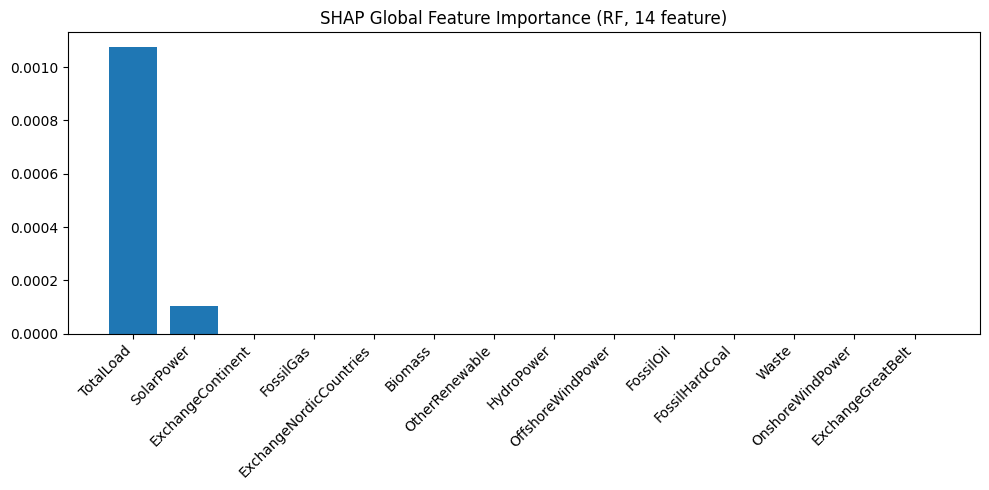

Epoch 1/100
1081/1081 ━━━━━━━━━━━━━━━━━━━━ 33s 30ms/step - loss: 0.0151 - val_loss: 0.0121
Epoch 2/100
1081/1081 ━━━━━━━━━━━━━━━━━━━━ 29s 27ms/step - loss: 0.0117 - val_loss: 0.0112
Epoch 3/100
1081/1081 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - loss: 0.0111 - val_loss: 0.0109
Epoch 4/100
1081/1081 ━━━━━━━━━━━━━━━━━━━━ 32s 29ms/step - loss: 0.0108 - val_loss: 0.0104
Epoch 5/100
1081/1081 ━━━━━━━━━━━━━━━━━━━━ 30s 27ms/step - loss: 0.0104 - val_loss: 0.0103
Epoch 6/100
1081/1081 ━━━━━━━━━━━━━━━━━━━━ 33s 30ms/step - loss: 0.0101 - val_loss: 0.0099
Epoch 7/100
1081/1081 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - loss: 0.0096 - val_loss: 0.0094
Epoch 8/100
1081/1081 ━━━━━━━━━━━━━━━━━━━━ 29s 27ms/step - loss: 0.0089 - val_loss: 0.0087
Epoch 9/100
1081/1081 ━━━━━━━━━━━━━━━━━━━━ 30s 28ms/step - loss: 0.0083 - val_loss: 0.0082
Epoch 10/100
1081/1081 ━━━━━━━━━━━━━━━━━━━━ 27s 25ms/step - loss: 0.0078 - val_loss: 0.0077
Epoch 11/100
1081/1081 ━━━━━━━━━━━━━━━━━━━━ 31s 29ms/step - loss: 0.0074 - val_loss: 0.00

KeyboardInterrupt: 

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Sklearn Kütüphaneleri
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

# Keras / TensorFlow Kütüphaneleri
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import logging, random  # Tekrarlanabilirlik için
import shap            # SHAP açıklanabilirlik kütüphanesi

# ============================================================
# Sabitler
# ============================================================
SEED = 42
CSV_PATH = 'clean-dataset.csv'  # Bu dosyanın aynı klasörde olduğundan emin ol
INPUT_LEN = 120     # Geçmiş girdi penceresi uzunluğu (ör: 5 gün * 24 saat = 120)
OUTPUT_LEN = 24     # Tahmin edilecek gelecek çıktı uzunluğu (ör: 1 gün * 24 saat)
TARGET_COL = 'TotalLoad'

# ============================================================
# Tohumlar (seed) – Tekrarlanabilirlik için
# ============================================================
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
logging.getLogger('pyswarms').setLevel(logging.WARNING)

# ============================================================
# 1) Veriyi yükle
# ============================================================
df = pd.read_csv(CSV_PATH)
df.columns = df.columns.str.strip()

# 2) Zaman varsa sırala
if 'HourUTC' in df.columns:
    df['HourUTC'] = pd.to_datetime(df['HourUTC'], errors='coerce')
    df = df.sort_values('HourUTC').reset_index(drop=True)

# ============================================================
# 3) Sütun bazlı MinMax ölçekleme
# ============================================================
scalers = {}
for col in [c for c in df.columns if c != 'HourUTC']:
    sc = MinMaxScaler()
    df[col] = sc.fit_transform(df[[col]])
    scalers[col] = sc

# ============================================================
# 4) Pencereleme (Kayar pencereler oluşturma)
# ============================================================
def create_sliding_windows(df: pd.DataFrame, input_len=120, output_len=24, target_col='TotalLoad'):
    """
    Zaman serisi için 3D kayar pencereleri oluşturur.
    X: (num_samples, input_len, num_features)
    y: (num_samples, output_len)
    """
    features = [c for c in df.columns if c != 'HourUTC']
    data = df[features].values
    target = df[target_col].values

    X, y = [], []
    for i in range(len(data) - input_len - output_len):
        # Geçmiş 'input_len' saat → girdi (X)
        X.append(data[i:i+input_len])
        # Sonraki 'output_len' saat → hedef (y)
        y.append(target[i+input_len:i+input_len+output_len])

    return np.array(X), np.array(y), features

X, y, feature_names = create_sliding_windows(
    df, input_len=INPUT_LEN, output_len=OUTPUT_LEN, target_col=TARGET_COL
)
print(f"(A) Pencereleme: X: {X.shape} | y: {y.shape} | features: {len(feature_names)}")

# ============================================================
# 5) Random Forest ile Özellik Seçimi
#    (Senin yazdığın FS kodu + SHAP eklenecek bölüm)
# ============================================================

# X: (n_samples, n_steps, n_features) → RF için 2D'ye düzleştirme
n_samples, n_steps, n_features = X.shape
X_flat = X.reshape(n_samples, n_steps * n_features)  # (n_samples, 120*14)

# Hedef değişken (y) olarak 24 saatlik hedefin ilk saatini kullanıyoruz.
y_flat = y[:, 0]  # İlk saati seçiyoruz

# 5.1) Random Forest Regressor'ı eğit
rf = RandomForestRegressor(
    n_estimators=100,
    random_state=SEED,
    max_depth=5,
    n_jobs=-1
)
rf.fit(X_flat, y_flat)

# 5.2) Zaman boyutu üzerinden ortalama alarak orijinal feature önemleri
feature_importances_3D = rf.feature_importances_.reshape(n_steps, n_features)
mean_importances = feature_importances_3D.mean(axis=0)

threshold_value = np.median(mean_importances)

selected_idx = np.where(mean_importances > threshold_value)[0]

# Geçmiş TotalLoad'u her zaman seç: Zorunlu özellik
pl_idx = feature_names.index(TARGET_COL)
if pl_idx not in selected_idx:
    selected_idx = np.append(selected_idx, pl_idx)

selected_idx = np.sort(selected_idx)
selected_feats = [feature_names[i] for i in selected_idx]
print(f"(B) RF Seçimi ({len(selected_feats)} özellik): {selected_feats} [Geçmiş {TARGET_COL} ZORUNLU]")

# RF seçimine göre 3D veriyi filtrele (nihai model için)
X_selected = X[:, :, selected_idx]

# ============================================================
# 5.3) SHAP ile RF modelinin feature önemini analiz etme
#      (14 feature için global önem sıralaması)
# ============================================================

print("\n--- SHAP Analizi Başlıyor (RF modeli) ---")

# SHAP açıklayıcı (TreeExplainer, ağaç modelleri için ideal)
explainer = shap.TreeExplainer(rf)

# Hesabı hızlandırmak için örnek alt küme seç
sample_size = min(500, X_flat.shape[0])
X_sample_flat = X_flat[:sample_size]

# SHAP değerlerini hesapla (örnek_sayısı, n_steps*n_features)
shap_values_flat = explainer.shap_values(X_sample_flat)

# 2D'den tekrar 3D'ye aç → (örnek_sayısı, n_steps, n_features)
shap_values_3D = shap_values_flat.reshape(-1, n_steps, n_features)

# Global önem: tüm örnekler ve zaman adımları boyunca ortalama |SHAP|
global_shap_importance = np.mean(np.abs(shap_values_3D), axis=(0, 1))  # (n_features,)

shap_df = pd.DataFrame({
    "feature": feature_names,
    "shap_importance": global_shap_importance
}).sort_values("shap_importance", ascending=False).reset_index(drop=True)

shap_df["shap_rank"] = shap_df.index + 1

# RF tarafından seçilen özellikleri işaretle
selected_set = set(selected_feats)
shap_df["selected_by_rf"] = shap_df["feature"].apply(lambda f: f in selected_set)

print("\n--- SHAP Global Feature Importance (14 feature) ---")
print(shap_df)

# İsteğe bağlı: Basit bir bar grafiği
plt.figure(figsize=(10, 5))
plt.bar(shap_df["feature"], shap_df["shap_importance"])
plt.xticks(rotation=45, ha='right')
plt.title("SHAP Global Feature Importance (RF, 14 feature)")
plt.tight_layout()
plt.show()

# ============================================================
# 6) Nihai LSTM Model Eğitimi ve Değerlendirme
#    (RF ile seçilen özellikler kullanılıyor)
# ============================================================

X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=SEED
)

# LSTM Model Tanımı
model = Sequential([
    tf.keras.Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(128, return_sequences=False),
    Dense(OUTPUT_LEN)  # 24 saatlik tahmin çıktısı
])
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Erken durdurma
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Model Eğitimi
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[es],
    verbose=1
)

# Tahmin
y_pred = model.predict(X_test, verbose=0)

# Inverse scaling (Orijinal ölçeğe dönüş)
tl_scaler = scalers[TARGET_COL]
y_test_inv = tl_scaler.inverse_transform(y_test.reshape(-1, 1)).reshape(y_test.shape)
y_pred_inv = tl_scaler.inverse_transform(y_pred.reshape(-1, 1)).reshape(y_pred.shape)

# Performans Metrikleri (Orijinal ölçekte)
mse_inv = mean_squared_error(y_test_inv.flatten(), y_pred_inv.flatten())
rmse_inv = np.sqrt(mse_inv)
r2_inv = r2_score(y_test_inv.flatten(), y_pred_inv.flatten())

print("\n--- Model Performansı (Orijinal Ölçek) ---")
print(f"(C) Test MSE (orijinal): {mse_inv:,.2f}")
print(f"(C) Test RMSE (orijinal): {rmse_inv:,.2f}")
print(f"(C) Test R²  (orijinal): {r2_inv:.4f}")

# Örnek görselleştirme (ilk test örneği)
plt.figure(figsize=(10, 5))
plt.plot(y_test_inv[0], label='Gerçek TotalLoad')
plt.plot(y_pred_inv[0], label='Tahmin Edilen TotalLoad')
plt.title('24 Saatlik Day-Ahead TotalLoad Tahmini (RF Özellik Seçimi ile)')
plt.xlabel('Saat')
plt.ylabel('TotalLoad (orijinal birim)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

(A) Pencereleme: X: (54008, 120, 14) | y: (54008, 24) | features: 14

🔎 5 FEATURE ile LSTM eğitimi / test değerlendirmesi
Seçilen feature’lar (5): ['TotalLoad', 'FossilGas', 'SolarPower', 'ExchangeContinent', 'ExchangeNordicCountries']  [TotalLoad ZORUNLU]
RMSE (orijinal): 135.49
R²   (orijinal): 0.9037

🔎 7 FEATURE ile LSTM eğitimi / test değerlendirmesi
Seçilen feature’lar (7): ['TotalLoad', 'FossilGas', 'SolarPower', 'OffshoreWindPower', 'ExchangeContinent', 'ExchangeGreatBelt', 'ExchangeNordicCountries']  [TotalLoad ZORUNLU]
RMSE (orijinal): 125.30
R²   (orijinal): 0.9177

🔎 10 FEATURE ile LSTM eğitimi / test değerlendirmesi
Seçilen feature’lar (10): ['TotalLoad', 'Biomass', 'FossilGas', 'FossilHardCoal', 'SolarPower', 'OnshoreWindPower', 'OffshoreWindPower', 'ExchangeContinent', 'ExchangeGreatBelt', 'ExchangeNordicCountries']  [TotalLoad ZORUNLU]
RMSE (orijinal): 133.40
R²   (orijinal): 0.9067

📊 FEATURE SAYISI KARŞILAŞTIRMASI (Orijinal Ölçek)
   k_features  RMSE_original  R2_orig

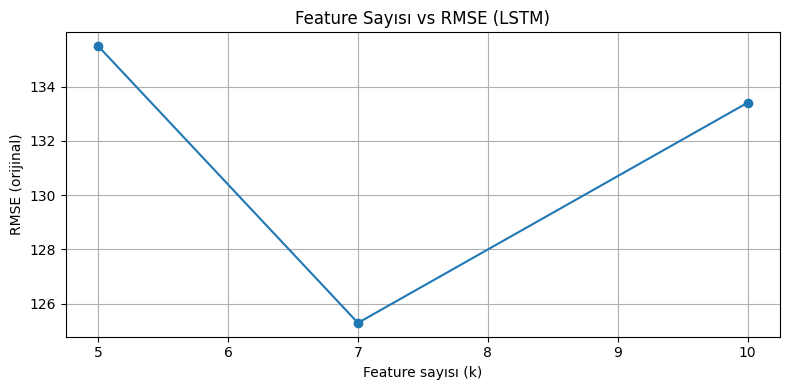

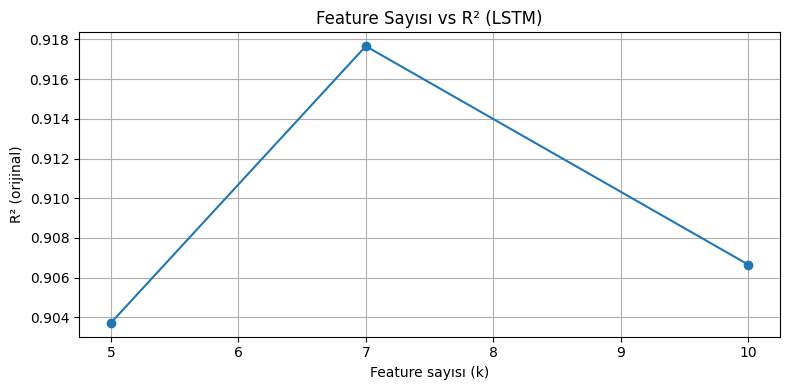


--- Seçilen Feature Set'leri ---
k=5: ['TotalLoad', 'FossilGas', 'SolarPower', 'ExchangeContinent', 'ExchangeNordicCountries']
k=7: ['TotalLoad', 'FossilGas', 'SolarPower', 'OffshoreWindPower', 'ExchangeContinent', 'ExchangeGreatBelt', 'ExchangeNordicCountries']
k=10: ['TotalLoad', 'Biomass', 'FossilGas', 'FossilHardCoal', 'SolarPower', 'OnshoreWindPower', 'OffshoreWindPower', 'ExchangeContinent', 'ExchangeGreatBelt', 'ExchangeNordicCountries']


In [4]:
# ============================================================
# ✅ RF Importance ile 5 / 7 / 10 Feature Seçip
# ✅ Aynı LSTM ile Performans Karşılaştırması (RMSE, R²)
#    (Orijinal ölçekte; TotalLoad geçmişi her zaman dahil)
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random, logging

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# ----------------------------
# Sabitler
# ----------------------------
SEED = 42
CSV_PATH = "clean-dataset.csv"
INPUT_LEN = 120
OUTPUT_LEN = 24
TARGET_COL = "TotalLoad"

# Tekrarlanabilirlik
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
logging.getLogger("pyswarms").setLevel(logging.WARNING)

# ----------------------------
# 1) Veriyi yükle ve sırala
# ----------------------------
df = pd.read_csv(CSV_PATH)
df.columns = df.columns.str.strip()

if "HourUTC" in df.columns:
    df["HourUTC"] = pd.to_datetime(df["HourUTC"], errors="coerce")
    df = df.sort_values("HourUTC").reset_index(drop=True)

if TARGET_COL not in df.columns:
    raise ValueError(f"Hedef sütun bulunamadı: {TARGET_COL}")

# ----------------------------
# 2) Sütun bazlı MinMax ölçekleme (HourUTC hariç)
# ----------------------------
scalers = {}
for col in [c for c in df.columns if c != "HourUTC"]:
    sc = MinMaxScaler()
    df[col] = sc.fit_transform(df[[col]])
    scalers[col] = sc

# ----------------------------
# 3) Sliding window
# ----------------------------
def create_sliding_windows(df: pd.DataFrame, input_len=120, output_len=24, target_col="TotalLoad"):
    features = [c for c in df.columns if c != "HourUTC"]
    data = df[features].values
    target = df[target_col].values

    X, y = [], []
    for i in range(len(data) - input_len - output_len):
        X.append(data[i:i + input_len])
        y.append(target[i + input_len:i + input_len + output_len])

    return np.array(X), np.array(y), features

X, y, feature_names = create_sliding_windows(
    df, input_len=INPUT_LEN, output_len=OUTPUT_LEN, target_col=TARGET_COL
)

print(f"(A) Pencereleme: X: {X.shape} | y: {y.shape} | features: {len(feature_names)}")

# ----------------------------
# 4) Random Forest ile importance (ilk saat hedefi: y[:,0])
# ----------------------------
n_samples, n_steps, n_features = X.shape
X_flat = X.reshape(n_samples, n_steps * n_features)
y_flat = y[:, 0]

rf = RandomForestRegressor(
    n_estimators=200,
    random_state=SEED,
    max_depth=8,
    n_jobs=-1
)
rf.fit(X_flat, y_flat)

# Zaman boyutu üzerinden ortalama importance
feature_importances_3D = rf.feature_importances_.reshape(n_steps, n_features)
mean_importances = feature_importances_3D.mean(axis=0)  # (n_features,)

# Büyükten küçüğe sıralama
importance_order = np.argsort(mean_importances)[::-1]

# ----------------------------
# 5) LSTM modeli (her feature set için aynı)
# ----------------------------
def build_lstm(input_shape):
    model = Sequential([
        tf.keras.Input(shape=input_shape),
        LSTM(128, return_sequences=False),
        Dense(OUTPUT_LEN)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss="mse")
    return model

# ----------------------------
# 6) Tam olarak K feature seç (TotalLoad zorunlu, toplam K olacak)
# ----------------------------
def select_top_k_with_target(importance_order, feature_names, target_col, k):
    if k < 1:
        raise ValueError("k en az 1 olmalı.")

    target_idx = feature_names.index(target_col)

    # Target hariç en iyi (k-1) feature’ı al
    top = [idx for idx in importance_order if idx != target_idx]
    selected = [target_idx] + top[: max(0, k - 1)]

    # Güvenlik: benzersiz ve sıralı
    selected = np.array(sorted(set(selected)), dtype=int)

    # Eğer set içinde tekrardan dolayı k küçüldüyse (teorik), tamamla
    if len(selected) < k:
        for idx in top:
            if idx not in selected:
                selected = np.append(selected, idx)
            if len(selected) == k:
                break
        selected = np.array(sorted(set(selected)), dtype=int)

    return selected

# ----------------------------
# 7) 5 / 7 / 10 karşılaştırma
# ----------------------------
FEATURE_SET_SIZES = [5, 7, 10]
results = []

for k in FEATURE_SET_SIZES:
    print("\n" + "=" * 70)
    print(f"🔎 {k} FEATURE ile LSTM eğitimi / test değerlendirmesi")
    print("=" * 70)

    selected_idx = select_top_k_with_target(
        importance_order=importance_order,
        feature_names=feature_names,
        target_col=TARGET_COL,
        k=k
    )
    selected_feats = [feature_names[i] for i in selected_idx]
    print(f"Seçilen feature’lar ({len(selected_feats)}): {selected_feats}  [TotalLoad ZORUNLU]")

    # 3D veriyi filtrele
    X_k = X[:, :, selected_idx]

    # Train/Test split (her k için aynı random_state)
    X_train, X_test, y_train, y_test = train_test_split(
        X_k, y, test_size=0.2, random_state=SEED
    )

    # Model
    model = build_lstm(input_shape=(X_train.shape[1], X_train.shape[2]))
    es = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

    model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=100,
        batch_size=32,
        callbacks=[es],
        verbose=0
    )

    # Tahmin
    y_pred = model.predict(X_test, verbose=0)

    # Orijinal ölçeğe dönüş (TotalLoad scaler)
    tl_scaler = scalers[TARGET_COL]
    y_test_inv = tl_scaler.inverse_transform(y_test.reshape(-1, 1)).reshape(y_test.shape)
    y_pred_inv = tl_scaler.inverse_transform(y_pred.reshape(-1, 1)).reshape(y_pred.shape)

    # Metrikler (orijinal ölçekte)
    rmse = np.sqrt(mean_squared_error(y_test_inv.flatten(), y_pred_inv.flatten()))
    r2 = r2_score(y_test_inv.flatten(), y_pred_inv.flatten())

    print(f"RMSE (orijinal): {rmse:,.2f}")
    print(f"R²   (orijinal): {r2:.4f}")

    results.append({
        "k_features": k,
        "selected_features": selected_feats,
        "RMSE_original": rmse,
        "R2_original": r2
    })

# ----------------------------
# 8) Sonuçları tablo + opsiyonel grafik
# ----------------------------
results_df = pd.DataFrame(results).sort_values("k_features").reset_index(drop=True)

print("\n" + "=" * 70)
print("📊 FEATURE SAYISI KARŞILAŞTIRMASI (Orijinal Ölçek)")
print("=" * 70)
print(results_df[["k_features", "RMSE_original", "R2_original"]])

# RMSE grafiği
plt.figure(figsize=(8, 4))
plt.plot(results_df["k_features"], results_df["RMSE_original"], marker="o")
plt.xlabel("Feature sayısı (k)")
plt.ylabel("RMSE (orijinal)")
plt.title("Feature Sayısı vs RMSE (LSTM)")
plt.grid(True)
plt.tight_layout()
plt.show()

# R2 grafiği
plt.figure(figsize=(8, 4))
plt.plot(results_df["k_features"], results_df["R2_original"], marker="o")
plt.xlabel("Feature sayısı (k)")
plt.ylabel("R² (orijinal)")
plt.title("Feature Sayısı vs R² (LSTM)")
plt.grid(True)
plt.tight_layout()
plt.show()

# İstersen seçilen feature listesini de detaylı yazdır:
print("\n--- Seçilen Feature Set'leri ---")
for row in results:
    print(f"k={row['k_features']}: {row['selected_features']}")